# Exploring Polarimetry from HARP2 

**Author:** This code was modified by Yanna Fidai and is based on the tutorial Visualize Data from the Hyper-Angular Rainbow Polarimeter (HARP2) by Sean Foley, Meng Gau, and Ian Carroll URL: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/harp2-basic-visualizations/ [accessed 08/08/24]

<div class="alert alert-success" role="alert">


<div


In [1]:
from pathlib import Path  # Module for handling file system paths
from tempfile import TemporaryDirectory  # Module for creating temporary directories

from scipy.ndimage import gaussian_filter1d  # Function for applying a 1D Gaussian filter to an array
from matplotlib import animation  # Module for creating animations with Matplotlib
import cartopy.crs as ccrs  # Module for working with cartographic projections and coordinate systems
import earthaccess  # Library for accessing Earth data, such as satellite imagery and climate data
import matplotlib.pyplot as plt  # Module for creating static, animated, and interactive visualizations in Python
import numpy as np  # Library for numerical operations on arrays
import xarray as xr  # Library for working with labeled multi-dimensional arrays (e.g., datasets)

# Authenticate the user with earthaccess, potentially persisting credentials for future sessions
auth = earthaccess.login(persist=True)

bounding_box: a tuple representing spatial bounds in the form (lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat)

QUEUEING TASKS | :   0%|          | 0/42 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/42 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/42 [00:00<?, ?it/s]

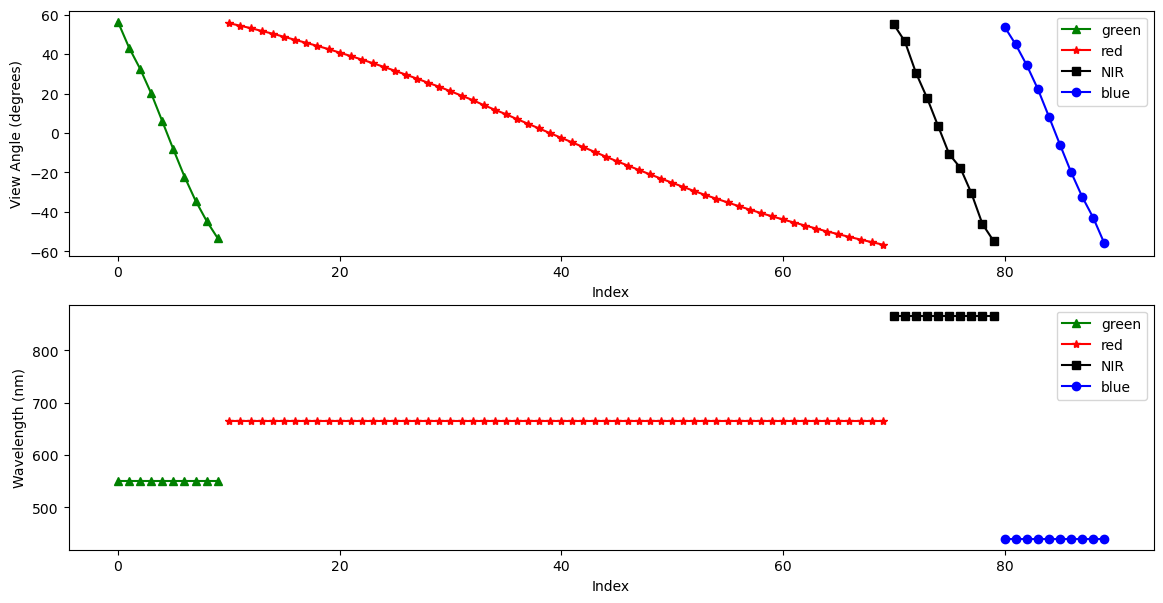

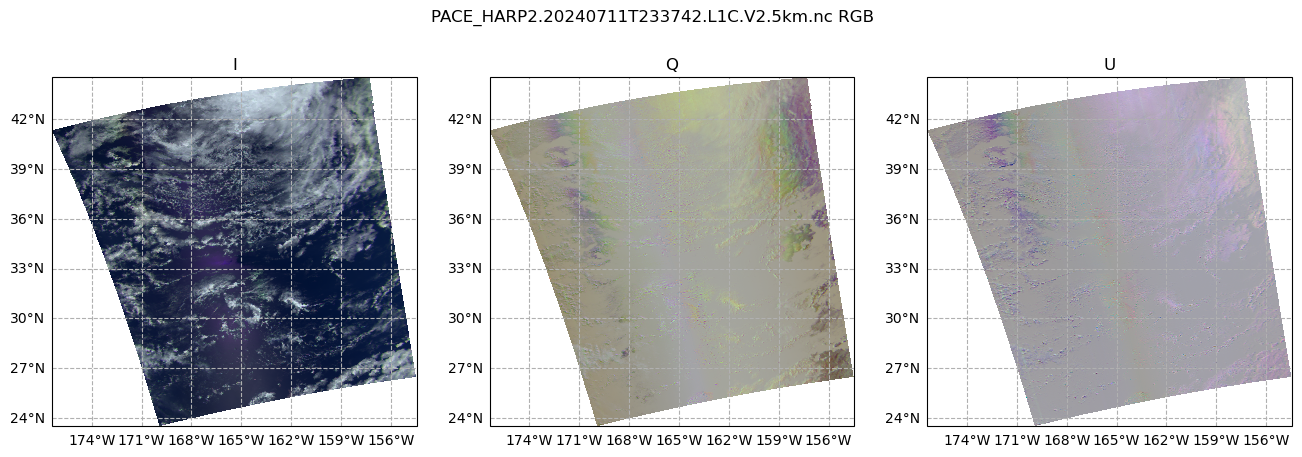

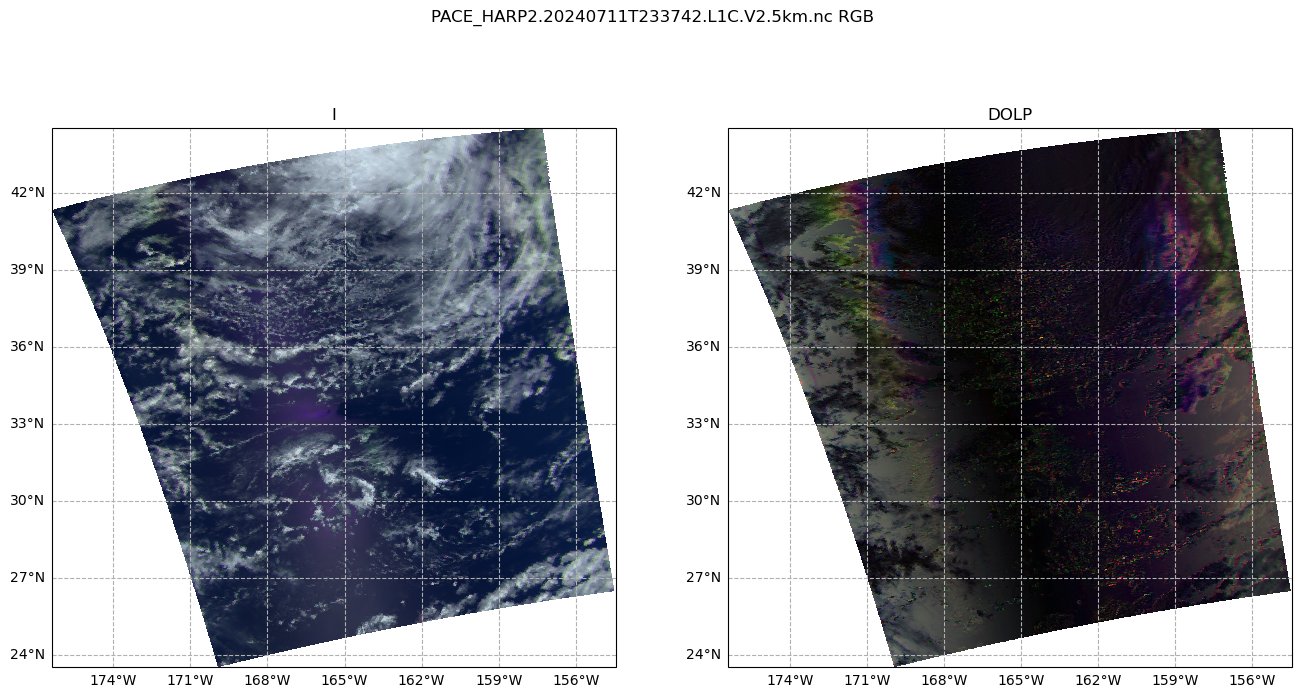

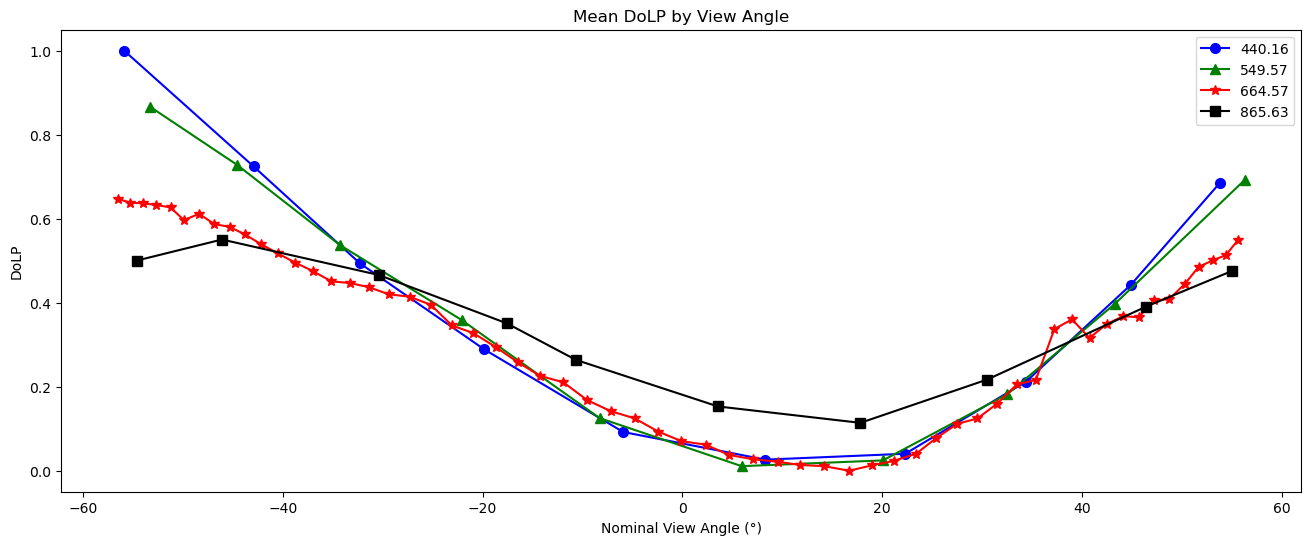

In [2]:
# Define the time span and geographical bounding box for the data search
tspan = ("2024-07-07", "2024-08-05")  # Temporal range for data
bbox = (-159, 26, -157.5, 28)  # Bounding box: (west, south, east, north)

# Search for data using the specified parameters (product, time, and location)
results = earthaccess.search_data(
    short_name="PACE_HARP2_L1C_SCI",  # Product identifier
    temporal=tspan,
    bounding_box=bbox,
)

# Check how many results were returned from the search
len(results)

# Open the results to get paths to the data files
paths = earthaccess.open(results)

# Load different parts of the dataset
prod = xr.open_dataset(paths[10])  # Load the main dataset
view = xr.open_dataset(paths[10], group="sensor_views_bands").squeeze()  # Load sensor view and band data
geo = xr.open_dataset(paths[10], group="geolocation_data").set_coords(["longitude", "latitude"])  # Load geolocation data
obs = xr.open_dataset(paths[10], group="observation_data").squeeze()  # Load observation data

# Merge all loaded datasets into a single dataset
dataset = xr.merge((prod, obs, geo))
dataset

# Extract sensor view angles and wavelengths from the view dataset
angles = view["sensor_view_angle"]
wavelengths = view["intensity_wavelength"]

# Create a plot with two subplots for view angles and wavelengths
fig, (ax_angle, ax_wavelength) = plt.subplots(2, 1, figsize=(14, 7))
ax_angle.set_ylabel("View Angle (degrees)")
ax_angle.set_xlabel("Index")
ax_wavelength.set_ylabel("Wavelength (nm)")
ax_wavelength.set_xlabel("Index")

# Define data for plotting with specific ranges, colors, markers, and labels
plot_data = [
    (0, 10, "green", "^", "green"),
    (10, 70, "red", "*", "red"),
    (70, 80, "black", "s", "NIR"),  # NIR: Near-Infrared
    (80, 90, "blue", "o", "blue"),
]

# Plot the view angles and wavelengths
for start_idx, end_idx, color, marker, label in plot_data:
    ax_angle.plot(
        np.arange(start_idx, end_idx),
        angles[start_idx:end_idx],
        color=color,
        marker=marker,
        label=label,
    )
    ax_wavelength.plot(
        np.arange(start_idx, end_idx),
        wavelengths[start_idx:end_idx],
        color=color,
        marker=marker,
        label=label,
    )
ax_angle.legend()
ax_wavelength.legend()
plt.show()

# Extract Stokes parameters (I, Q, U) from the dataset
stokes = dataset[["i", "q", "u"]]

# Identify indices for nadir views in green, red, and blue wavelength bands
green_nadir_idx = np.argmin(np.abs(angles[:10].values))
red_nadir_idx = 10 + np.argmin(np.abs(angles[10:70].values))
blue_nadir_idx = 80 + np.argmin(np.abs(angles[80:].values))

# Select corresponding Stokes parameters for RGB channels
rgb_stokes = stokes.isel(
    {
        "number_of_views": [red_nadir_idx, green_nadir_idx, blue_nadir_idx],
    }
)

# Normalize the selected Stokes parameters and apply a gamma correction
rgb_stokes = (rgb_stokes - rgb_stokes.min()) / (rgb_stokes.max() - rgb_stokes.min())
rgb_stokes = rgb_stokes ** (3 / 4)

# Create a mask to filter out non-valid data
window = rgb_stokes["i"].notnull().all("number_of_views")
crop_rgb_stokes = rgb_stokes.where(
    window.any("bins_along_track") & window.any("bins_across_track"),
    drop=True,
)

# Set up map projections for plotting
crs_proj = ccrs.PlateCarree(-170)  # Define a PlateCarree projection with central longitude
crs_data = ccrs.PlateCarree()

# Plot the RGB channels on a map with coastlines and gridlines
fig, ax = plt.subplots(1, 3, figsize=(16, 5), subplot_kw={"projection": crs_proj})
fig.suptitle(f'{prod.attrs["product_name"]} RGB')

for i, (key, value) in enumerate(crop_rgb_stokes.items()):
    ax[i].pcolormesh(value["longitude"], value["latitude"], value, transform=crs_data)
    ax[i].gridlines(draw_labels={"bottom": "x", "left": "y"}, linestyle="--")
    ax[i].coastlines(color="grey")
    ax[i].set_title(key.upper())

# Select Degree of Linear Polarization (DoLP) data for RGB channels
rgb_dolp = dataset["dolp"].isel(
    {
        "number_of_views": [red_nadir_idx, green_nadir_idx, blue_nadir_idx],
    }
)
crop_rgb_dolp = rgb_dolp.where(
    window.any("bins_along_track") & window.any("bins_across_track"),
    drop=True,
)

# Merge the cropped DoLP data with the cropped RGB Stokes parameters
crop_rgb = xr.merge((crop_rgb_dolp, crop_rgb_stokes))

# Normalize and plot the data for RGB and DoLP
fig, ax = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={"projection": crs_proj})
fig.suptitle(f'{prod.attrs["product_name"]} RGB')

for i, (key, value) in enumerate(crop_rgb[["i", "dolp"]].items()):
    ax[i].pcolormesh(value["longitude"], value["latitude"], value / value.max(), transform=crs_data)
    ax[i].gridlines(draw_labels={"bottom": "x", "left": "y"}, linestyle="--")
    ax[i].coastlines(color="grey")
    ax[i].set_title(key.upper())

# Calculate the mean DoLP across all track bins and normalize it
dolp_mean = dataset["dolp"].mean(["bins_along_track", "bins_across_track"])
dolp_mean = (dolp_mean - dolp_mean.min()) / (dolp_mean.max() - dolp_mean.min())

# Plot the mean DoLP against view angles for different wavelength bands
fig, ax = plt.subplots(figsize=(16, 6))
wv_uq = np.unique(wavelengths.values)
plot_data = [("b", "o"), ("g", "^"), ("r", "*"), ("k", "s")]
for wv_idx in range(4):
    wv = wv_uq[wv_idx]
    wv_mask = wavelengths.values == wv
    c, m = plot_data[wv_idx]
    ax.plot(
        angles.values[wv_mask],
        dolp_mean[wv_mask],
        color=c,
        marker=m,
        markersize=7,
        label=str(wv),
    )
ax.legend()
ax.set_xlabel("Nominal View Angle (°)")
ax.set_ylabel("DoLP")
ax.set_title("Mean DoLP by View Angle")
plt.show()


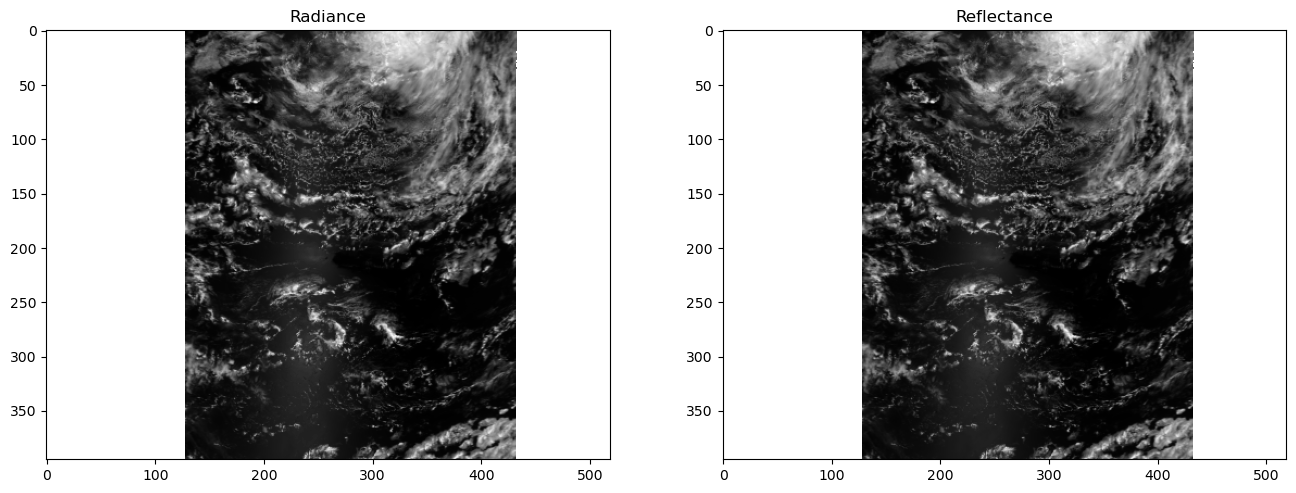

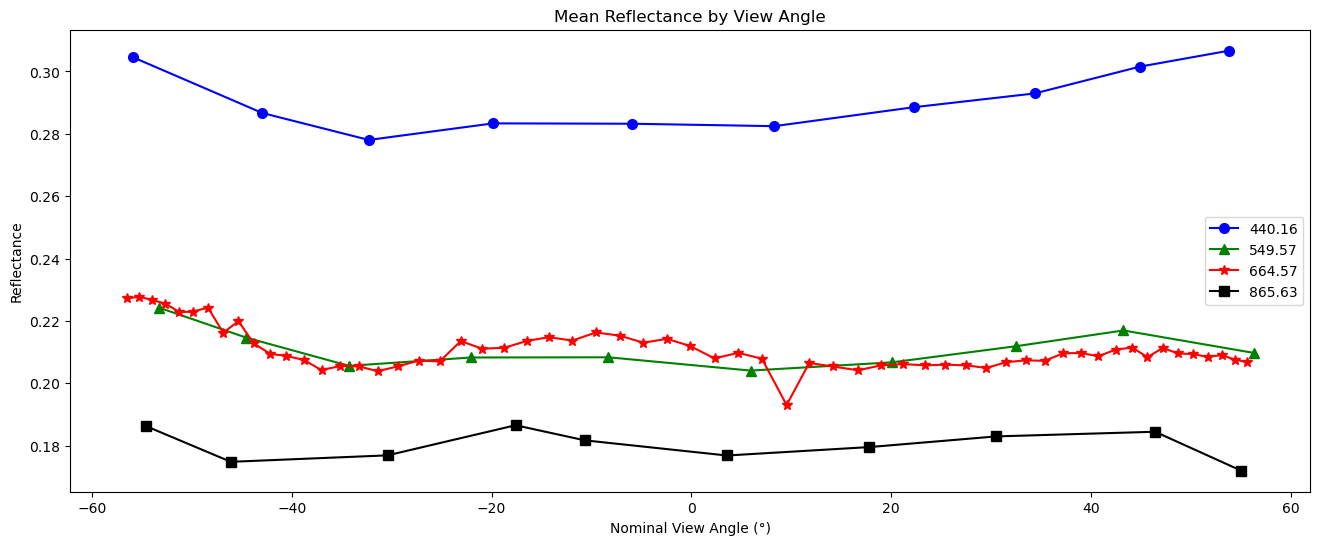

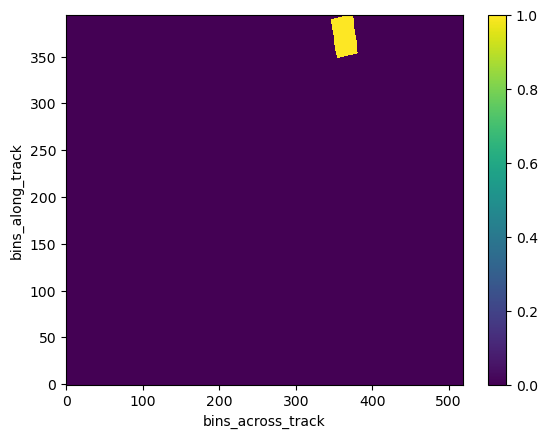

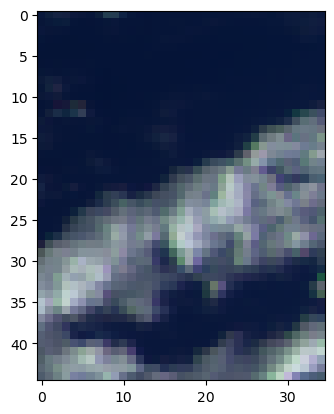

In [3]:
def rad_to_refl(rad, f0, sza, r):
    """Convert radiance to reflectance.
    
    Args:
        rad: Radiance (measured energy).
        f0: Solar irradiance (incident solar radiation).
        sza: Solar zenith angle (angle between the sun and the vertical).
        r: Sun-Earth distance (in Astronomical Units, AU).

    Returns: Reflectance (ratio of reflected to incident radiation).
    """
    # Calculate reflectance using the formula
    return (r**2) * np.pi * rad / np.cos(sza * np.pi / 180) / f0

# Convert the radiance data in the dataset to reflectance
refl = rad_to_refl(
    rad=dataset["i"],  # Radiance data from the dataset
    f0=view["intensity_f0"],  # Solar irradiance data
    sza=dataset["solar_zenith_angle"],  # Solar zenith angle from the dataset
    r=float(dataset.attrs["sun_earth_distance"]),  # Sun-Earth distance from the dataset attributes
)

# Plot the radiance and corresponding reflectance for the red channel
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(dataset["i"].sel({"number_of_views": red_nadir_idx})[::-1], cmap="gray")  # Plot radiance
ax[0].set_title("Radiance")
ax[1].imshow(refl.sel({"number_of_views": red_nadir_idx})[::-1], cmap="gray")  # Plot reflectance
ax[1].set_title("Reflectance")
plt.show()

# Plot the mean reflectance by view angle for different wavelength bands
fig, ax = plt.subplots(figsize=(16, 6))
wv_uq = np.unique(wavelengths.values)  # Unique wavelengths in the data
plot_data = [("b", "o"), ("g", "^"), ("r", "*"), ("black", "s")]  # Plot colors and markers
refl_mean = refl.mean(["bins_along_track", "bins_across_track"])  # Mean reflectance

# Plot reflectance for each wavelength band
for wv_idx in range(4):
    wv = wv_uq[wv_idx]
    wv_mask = wavelengths.values == wv
    c, m = plot_data[wv_idx]
    ax.plot(
        angles.values[wv_mask],
        refl_mean[wv_mask],
        color=c,
        marker=m,
        markersize=7,
        label=str(wv),
    )

ax.legend()
ax.set_xlabel("Nominal View Angle (°)")
ax.set_ylabel("Reflectance")
ax.set_title("Mean Reflectance by View Angle")
plt.show()

# Extract and normalize the reflectance data for the red wavelength range
refl_red = refl[..., 10:70]  # Select the red wavelength range
refl_pretty = (refl_red - refl_red.min()) / (refl_red.max() - refl_red.min())  # Normalize reflectance

# Apply a Gaussian filter for smoothing along the track direction
refl_pretty.data = gaussian_filter1d(refl_pretty, sigma=0.5, truncate=2, axis=2)

# Apply a gamma correction for visual enhancement
refl_pretty = refl_pretty ** (2 / 3)

# Create frames for the animation by sweeping through view angles
frames = np.arange(refl_pretty.sizes["number_of_views"])
frames = np.concatenate((frames, frames[-1::-1]))  # Append reversed frames for looping animation

# Set up the figure for animation
fig, ax = plt.subplots()
refl_pretty_flip = refl_pretty[::-1]  # Flip the data vertically for display
im = ax.imshow(refl_pretty_flip[{"number_of_views": 0}], cmap="gray")

# Update function for the animation
def update(i):
    im.set_data(refl_pretty_flip[{"number_of_views": i}])
    return im

# Create the animation and save it as a GIF
an = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=30)
filename = f'harp2_red_anim_{dataset.attrs["product_name"].split(".")[1]}.gif'
an.save(filename, writer="pillow")
plt.close()

# Output the processed reflectance data
refl_pretty

# Check the keys of the RGB Stokes data
rgb_stokes.keys()

# Extract latitude and longitude data from the RGB Stokes dataset
lat, lon = rgb_stokes["latitude"], rgb_stokes["longitude"]

# Create a mask for the bounding box region
bbox_mask = (lon > bbox[0]) * (lat > bbox[1]) * (lon < bbox[2]) * (lat < bbox[3])

# Check the shape of the cropped DoLP data
crop_rgb["dolp"].shape

# Plot the bounding box mask to visualize the selected region
bbox_mask[::-1].plot.imshow()

# Find the min and max indices for cropping based on the bounding box mask
bbox_mask_y, bbox_mask_x = np.where(bbox_mask)
rgb_arr = np.array(rgb_stokes["i"])[bbox_mask_y.min():bbox_mask_y.max(), bbox_mask_x.min():bbox_mask_x.max()]

# Display the cropped RGB data
plt.figure()
plt.imshow((rgb_arr)[::-1])
